## Image Registration Tutorial - Feature-based Registration

As usual, we first initialise the Python environment and define some helper functions for loading and plotting point sets.

NOTE: If you comment out line 7 by putting a # in front of the line, you can get 3D plots in an extra window in which you can rotate the view. You may need to restart the IPython kernel in the 'Kernel' menu above.

In [1]:
import numpy as np
from vtk import *
from vtk.util import numpy_support
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline

# Helper method to read point sets from a file
def vtk_point_read(filename):

    # load a vtk file as input
    reader = vtkPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()

    data = reader.GetOutput()

    x = np.zeros(data.GetNumberOfPoints())
    y = np.zeros(data.GetNumberOfPoints())
    z = np.zeros(data.GetNumberOfPoints())

    for i in range(data.GetNumberOfPoints()):
            x[i], y[i], z[i] = data.GetPoint(i)

    x = np.reshape(x, (1, len(x)))
    y = np.reshape(y, (1, len(y)))
    z = np.reshape(z, (1, len(z)))

    points = np.concatenate((x, y, z), axis=0)
    return points

# Helper function for plotting 3D point sets
def myplotin3D(pnt1_i,pnt2_i,title=''):
    fig = pylab.figure()
    ax = Axes3D(fig)
    ax.scatter(pnt1_i[0, 0::5], pnt1_i[1, 0::5], pnt1_i[2, 0::5], c='b')
    ax.scatter(pnt2_i[0, 0::5], pnt2_i[1, 0::5], pnt2_i[2, 0::5], c='r')
    ax.set_title(title,fontsize=16)
    ax.view_init(50,0)
    pyplot.show()

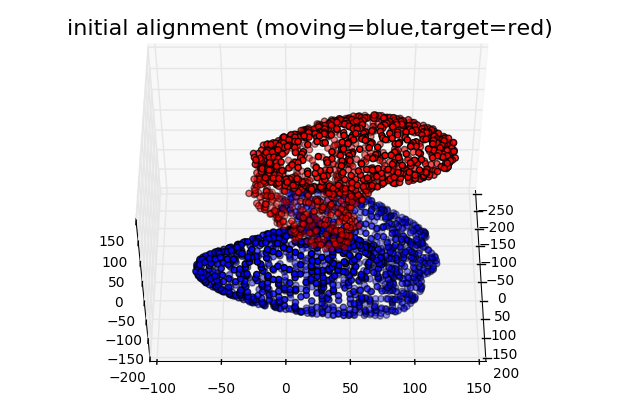

In [2]:
# Load point set data/liver1_dec.vtk
filename1 = "../data/liver1_dec.vtk"
pnt1 = vtk_point_read(filename1)
shp1 = pnt1.shape

# Copy the points and apply rigid transform
pnt2=pnt1.copy()
rotation_in = [[-0.3214, -0.5567, 0.7660],[-0.0637, -0.7944, -0.6040],[0.9448, -0.2429, 0.2198]]
trans_in = [10,20,-30]
pnt2 = np.dot(rotation_in,pnt1) + np.tile(trans_in,(shp1[1], 1)).transpose()

# Add Gaussian noise
sigma = max(pnt2.flatten()) * 0.02
noise = np.random.normal(0.0,sigma,pnt2.shape)
pnt2 = pnt2 + noise

# Initial position
myplotin3D(pnt1,pnt2,'initial alignment (moving=blue,target=red)')

### Umeyama method for rigid transformations

Below is a skeleton implementation of the Umeyama method for computing rigid-body transformation between corresponding point sets X and Y. For demonstration purposes, we use a single point set corresponding to a liver surface extracted from a real 3D CT image. The moving point set is generated by transforming the fixed point set and applying some Gaussian noise to it. Thus, the two point sets are not identical.

TASK: Finish the implementation by inserting the missing lines of code. You might want to check out the lecture notes for this.

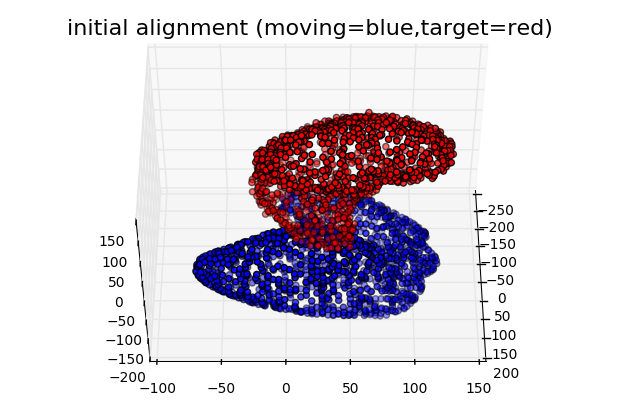

Rotation matrix=
[[-0.37163756 -0.74584642  0.55280976]
 [ 0.07391286 -0.61733809 -0.78321809]
 [ 0.92543093 -0.25021351  0.28455366]] 
Translation vector= [[-14.9492803  -13.83120091 -17.71138881]
 [-16.28051743 -14.21516436 -13.71954004]
 [-18.8247244  -15.31207696 -16.90988023]] mean= -16.0596770052


ValueError: operands could not be broadcast together with shapes (3,6330) (3,18990) 

In [17]:
# Implementation of the Umeyama method for computing rigid-body transformations between corresponding point sets X and Y
def umeyama_rigid(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape

    # Demean the point sets X and Y 
    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    X_demean =  X - X_mean
    Y_demean =  Y - Y_mean

    # Computing matrix XY' using demeaned point sets
    XY = np.dot(X_demean,Y_demean.transpose())

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
  
    # Determine rotation
    R = V.dot(U.transpose())

    # Determine translation
    t = Y_mean - np.dot(R,X_mean)#R * X_mean
    
    return R,t




# Load point set data/liver1_dec.vtk
filename1 = "../data/liver1_dec.vtk"
pnt1 = vtk_point_read(filename1)
shp1 = pnt1.shape

# Copy the points and apply rigid transform
pnt2=pnt1.copy()
rotation_in = [[-0.3214, -0.5567, 0.7660],[-0.0637, -0.7944, -0.6040],[0.9448, -0.2429, 0.2198]]
trans_in = [10,20,-30]
pnt2 = np.dot(rotation_in,pnt1) + np.tile(trans_in,(shp1[1], 1)).transpose()

# Add Gaussian noise
sigma = max(pnt2.flatten()) * 0.02
noise = np.random.normal(0.0,sigma,pnt2.shape)
pnt2 = pnt2 + noise


# Initial position
myplotin3D(pnt1,pnt2,'initial alignment (moving=blue,target=red)')

# Running Umeyama method
R, t,ymean = umeyama_rigid(pnt1,pnt2)
print "Rotation matrix=\n",R,"\nTranslation vector=",t

# After registration
pnt1 = np.dot(R,pnt1) + np.tile(t, (shp1[1], 1)).transpose()
myplotin3D(pnt1,pnt2,'after registration (moving=blue,target=red)')

### Umeyama method for similarity transformations

In the lecture, we have only discussed the basic Umeyama method as above. Now, we will implement a more advaned variant that can determine a similarity transformation (i.e. rotations + translation + scaling).

TASK: a) Finish the implementation below by inserting your code from above, b) try to understand what the additional lines of code do. References are given to the equations in the original work by Umeyama which can be found here: http://web.stanford.edu/class/cs273/refs/umeyama.pdf

In [ ]:
# Implementation of the Umeyama method for computing similarity transformations between corresponding point sets X and Y
def umeyama_similarity(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape

    # Demean the point sets X and Y
    X_mean = # INSERT CODE HERE
    Y_mean = # INSERT CODE HERE
    X_demean =  # INSERT CODE HERE
    Y_demean =  # INSERT CODE HERE

    # Computing matrix XY' using demeaned and NORMALISED point sets (divide by the number of points n)
    # See Equation (38) in the paper
    XY = # INSERT CODE HERE

    # Determine variances of points X and Y, see Equation (36),(37) in the paper
    X_var = np.mean(np.sum(X_demean*X_demean, 0))
    Y_var = np.mean(np.sum(Y_demean*Y_demean, 0))

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
    
    # Determine rotation
    R = # INSERT CODE HERE
    
    # Determine the scaling, see Equation (42) in the paper (assume S to be the identity matrix, so ignore)
    c = # INSERT CODE HERE

    # Determine translation, see Equation (41) in the paper
    t = # INSERT CODE HERE

    return R,c,t




# Load point set
filename1 = "../data/liver1_dec.vtk"
pnt1 = vtk_point_read(filename1)
shp1 = pnt1.shape

# Copy the points and transform them.
pnt2=pnt1.copy()
rotation_in = [[-0.3214, -0.5567, 0.7660],[-0.0637, -0.7944, -0.6040],[0.9448, -0.2429, 0.2198]]
scale_in = 2
trans_in = [10,20,-30]
pnt2 = scale_in * np.dot(rotation_in,pnt1) + np.tile(trans_in,(shp1[1], 1)).transpose()

# Add Gaussian noise
sigma = max(pnt2.flatten()) * 0.02
noise = np.random.normal(0.0,sigma,pnt2.shape)
pnt2 = pnt2 + noise


# Initial position
myplotin3D(pnt1,pnt2,'initial alignment (moving=blue,target=red)')

# Running Umeyama method
R, c, t = umeyama_similarity(pnt1,pnt2)
print "Rotation matrix=\n",R,"\nScaling coefficient=",c,"\nTranslation vector=",t

# After registration
pnt1 = c * np.dot(R,pnt1) + np.tile(t, (shp1[1], 1)).transpose()
myplotin3D(pnt1,pnt2,'after registration (moving=blue,target=red)')